In [11]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt

# Station utilization
The KPI station utilization should show how many stations have low utilization.  
This information can therefore be used to identify stations that are not profitable.  

We will calculate hourly whether a station was used or not.
To interpret these values, we will then look at a time interval, e.g. 1 day and
calculate the average utilization per station. We will then set a threshold for
the average utilization and count all stations whose average utilization is below
the threshold.  

We will also give the possibility to visualize the underutilized stations on a map.

In [12]:
trips_df = pd.read_pickle('../00_data/trips.pkl')
stations_df = pd.read_pickle('../00_data/stations.pkl')
stations_df = stations_df.set_index("station_id")

First we will create a dataframe where one column represents the number of
trips per hour per station. It is easy to determine from that dataframe whether
a station is used or not.

In [27]:
station_ids = np.unique(
    np.concatenate([trips_df["start_station_id"], trips_df["end_station_id"]])
)

In [28]:
dates = pd.date_range(start='2019-01-01', end='2019-12-31', freq='h')

In [29]:
full_index = pd.MultiIndex.from_product([station_ids, dates], names=['station_id', 'date'])

In [30]:
trips_df["start_time_floored"] = trips_df["start_time"].dt.floor("h")
trips_per_station_hour = trips_df.groupby(
    ["start_station_id", "start_time_floored"]
).size()
trips_per_station_hour = (
    trips_per_station_hour.reindex(full_index).fillna(0).to_frame("n_trips")
)


Next we will define a method (`get_station_utilization`) to calculate the station utilization for each station
in a defined time interval. We will return the results as a dataframe.

In [18]:
def get_station_utilization(time_interval):
    station_utilization = trips_per_station_hour.loc[(slice(None), time_interval), :]
    station_utilization = (
        station_utilization[station_utilization["n_trips"] != 0]
        .groupby(level=[0])
        .count()
    )
    station_utilization = station_utilization.reindex(station_ids).fillna(0)
    station_utilization = station_utilization.rename(columns={'n_trips': 'days_used'})
    station_utilization['station_usage'] = station_utilization['days_used'] / len(time_interval)
    return station_utilization

We also define methods to get and print the number of underutilized stations
for a specific threshold and the number of unused stations. 

In [19]:
def get_n_underutilized_stations(station_utilization, threshold):
    station_utilization_kpi = len(station_utilization[
        station_utilization["station_usage"] < threshold
    ])
    return station_utilization_kpi

def get_n_unused_stations(station_utilization, threshold):
    return len(station_utilization[station_utilization["station_usage"] == 0])


In [20]:
def print_utilization_summary(station_utilization, threshold):
    n_underutilized_stations = get_n_underutilized_stations(
        station_utilization, threshold
    )
    n_unused_stations = get_n_unused_stations(station_utilization, threshold)
    print(
        f"{n_underutilized_stations} ({n_underutilized_stations/len(station_utilization) * 100:.2f}%) stations are underutilized"
    )
    print(
        f"{get_n_unused_stations(station_utilization, threshold)} ({n_unused_stations/len(station_utilization) * 100:.2f}%) stations are unused"
    )


Now let's look at the number of underutilized stations and unused stations for an
arbitrary day (04.12.2019).

In [32]:
station_utilization = get_station_utilization(
    pd.date_range(start="2019-12-04 00:00", end="2019-12-04 23:59", freq="h")
)
print_utilization_summary(station_utilization, threshold=0.2)

124 (83.78%) stations are underutilized
57 (38.51%) stations are unused


As we can see the number of underutilzed and unused stations is very high. We 
have to keep in mind that the specified time interval (1 day) also includes night
time. However, still the number of unused stations is high. 

Next we will calculate the number of underutilized stations and unused stations
for each day of the year. Then we can plot these numbers to see the trend.

In [22]:


utilization_over_year = pd.date_range(
    start="2019-01-01", end="2019-12-31", freq="d"
)
# print all methods of the object 
(utilization_over_year[0].floor("h"))

Timestamp('2019-01-01 00:00:00')

In [23]:
utilization_over_year = pd.date_range(
    start="2019-01-01", end="2019-12-31", freq="d"
).to_frame(name="date")

# Note: We use a for loop here, which is very efficient. However, the execution
# time is still very short.
station_utilization
for index, row in utilization_over_year.iterrows():
	start = row['date'].floor("h")
	end = (row['date'] + pd.Timedelta(hours=23)).floor("h")


	station_utilization = pd.date_range(start, end, freq="h")
	station_utilization = get_station_utilization(
        pd.date_range(start, end, freq="h")
    )

	utilization_over_year.loc[index, "unused_stations"] = get_n_unused_stations(
		station_utilization, threshold=0.2
	)
	utilization_over_year.loc[index, "underutilized_stations"] = get_n_underutilized_stations(
		station_utilization, threshold=0.2
	)
utilization_over_year = utilization_over_year.set_index("date")

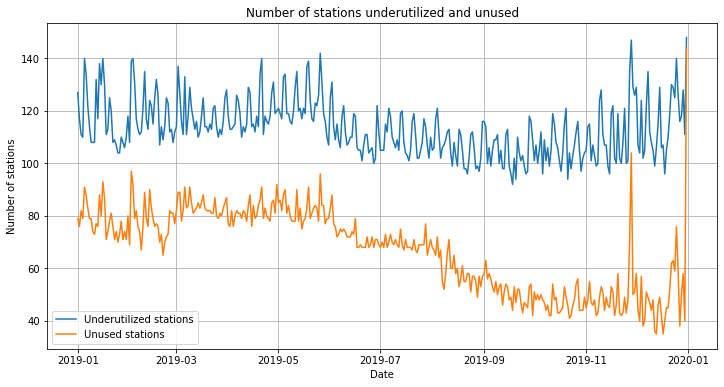

In [24]:
# plot utilization over year
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(utilization_over_year.index, utilization_over_year["underutilized_stations"])
ax.plot(utilization_over_year.index, utilization_over_year["unused_stations"])
ax.legend(["Underutilized stations", "Unused stations"])
ax.set_xlabel("Date")
ax.set_ylabel("Number of stations")
ax.set_title("Number of stations underutilized and unused")
ax.grid()
plt.show()


## Drawing underutilized stations on a map
Next we will draw the underutilized stations on a map. We will do this for a 
specific time interval. 

In [25]:
def draw_underutilized_stations(station_utilization, threshold):
    underutilized_stations = station_utilization[
        station_utilization["station_usage"] < threshold
    ]
    stations = stations_df.loc[underutilized_stations.index]
    stations = stations.merge(underutilized_stations, left_index=True, right_index=True)
    la_map = folium.Map(
        location=(
            34.052235,
            -118.243683,
        ),  # the orig mean values as location coordinates
        zoom_start=11,
        control_scale=True,
        max_zoom=20,
    )

    for index, row in stations.iterrows():
        days_used = int(row['days_used'])
        popup = folium.Popup(
            html=f"Station ID: <b>{index}</b><br>Days used: <b>{days_used}</b>",
			max_width=100,
			min_width=100,
        )
        color = 'red' if days_used == 0 else 'orange'
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=popup,
            icon=folium.Icon(color=color),
        ).add_to(la_map)

    return la_map


In [26]:
draw_underutilized_stations(station_utilization, threshold=0.2)